In [2]:
import pandas as pd
import toml
from tqdm import tqdm
from pathlib import Path
from skimage import io
from skimage.exposure import is_low_contrast
from skimage import measure
import torch
import numpy as np
import torch.nn.functional as F
import cv2
from skimage.color import rgb2gray
from skimage.exposure import histogram
import matplotlib.pyplot as plt
import skimage
from skimage.filters import threshold_mean
from skimage.segmentation import clear_border
from skimage.morphology import convex_hull_object, remove_small_objects

In [3]:
csv ='/Users/beantown/PycharmProjects/master-thesis/data/preprocessed/'
cleansed ='/Users/beantown/PycharmProjects/master-thesis/data/preprocessed/cleansed'
datasets = '/Users/beantown/PycharmProjects/master-thesis/data/preprocessed/datasets/' 
config = toml.load('./datasets.toml')

In [4]:
def pad_image(image, m):
    white = [255,255,255]
    image = cv2.copyMakeBorder(image, m,m,m,m, cv2.BORDER_CONSTANT, value=white)
    x = torch.tensor(np.array([image.T]))
    
    # define patch size properties for padding and unfolding
    kc, kh, kw = 3, m, m  # kernel size
    dc, dh, dw = 3, m, m  # stride

    # Pad to multiples of m. If image is too small -> go to next image
    x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
                  x.size(1)%kh // 2, x.size(1)%kh // 2,
                  x.size(0)%kc // 2, x.size(0)%kc // 2), mode='constant',value=255)
    return x

In [5]:
def get_patches(x,m):
    kc, kh, kw = 3, m, m  # kernel size
    dc, dh, dw = 3, m, m  # stride
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    return patches.contiguous().view(-1, kc, kh, kw)

In [6]:
def read_img(path, df, i):
    return io.imread(cleansed + '/' + df.loc[i].fnames + '.png')

In [7]:
def get_mean(image):
    buffer_size = 20
    connectivity=2
    min_area=100000
    image = io.imread(cleansed + '/2_13894_4797LR.png')
    gray = rgb2gray(image)
    blurred_image = skimage.filters.gaussian(gray, sigma=10.0)
    histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
    t = threshold_mean(blurred_image)
    binary_mask = blurred_image < t
    binary_mask = binary_mask.astype(np.uint8)
    #print(type(binary_mask))
#    binary_mask = ~binary_mask
    return measure.regionprops(binary_mask, gray)[0].intensity_mean

In [8]:
# arguments must be in the specified order, matching regionprops
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [9]:
from skimage.util import img_as_float

In [10]:
def select(patches, selection, n, img):
   # evaluate patch -> cast2 numpy
    patches = patches.numpy()
    selected_metric_values = []
    selected_patches = []
    selected_patch_ids = []
    mean_img = get_mean(img)

    if selection == 'random':
        decending = True
        for patch_id, patch in enumerate(patches):
            mc0 = img_as_float(patch[0]).mean()
            mc1 = img_as_float(patch[1]).mean()
            mc2 = img_as_float(patch[2]).mean()
            m = ((mc0 + mc1 + mc2) / 3)
            
            if m <= 0.8:
                selected_patches.append(patch)
                labels = np.ones_like(patch.T, dtype=int)                
                variance = measure.regionprops(labels, patch.T, extra_properties=[image_stdev])[0].image_stdev
                selected_metric_values.append(variance)
                selected_patch_ids.append(patch_id)
        
    
    elif selection == 'text':
        decending = True
        for patch_id, patch in enumerate(patches):
            mc0 = img_as_float(patch[0]).mean()
            mc1 = img_as_float(patch[1]).mean()
            mc2 = img_as_float(patch[2]).mean()            
            m = ((mc0 + mc1 + mc2) / 3)
            
            if m <= 0.85:
                gray = rgb2gray(patch.T)
                hist, hist_centers = skimage.exposure.histogram(gray, normalize=True)
                hist_centers = hist_centers[:-10]
                hist = hist[:-10]
                arr = gray > 0.25                
                forground = np.count_nonzero(arr==0)
                selected_patches.append(patch)
                labels = np.ones_like(patch.T, dtype=int)                
                variance = forground
                selected_metric_values.append(variance-m)
                selected_patch_ids.append(patch_id)

    elif selection == 'mean':
        decending = True
        for patch_id, patch in enumerate(patches):            
            mc0 = img_as_float(patch[0]).mean()
            mc1 = img_as_float(patch[1]).mean()
            mc2 = img_as_float(patch[2]).mean()            
            m = ((mc0 + mc1 + mc2) / 3)            
                
            if m <= 0.85:
                selected_patches.append(patch)

                dc0 = abs(mc0 - 0.6143)
                dc1 = abs(mc1 - 0.6884)
                dc2 = abs(mc2 - 0.7665)                                
                td = dc0 + dc1 + dc2
                selected_metric_values.append((td-m))
                selected_patch_ids.append(patch_id)
        
    
    selected_metric_values = np.array(selected_metric_values)
    idx = np.argsort(selected_metric_values)
    selected_patches = np.array(selected_patches)[idx]
    selected_patch_ids = np.array(selected_patch_ids)[idx]
    
    if selection == 'random':
        if len(selected_patches) < n:
            results = selected_patches
        else:
            idx = np.random.randint(selected_patches.shape[0], size=n)
            results = selected_patches[idx]
    elif decending:
        results = selected_patches[selected_patches.shape[0]-n:]
    else:
        results = selected_patches[:n]
        
    return results

In [11]:
def save(datasets, selected, nr, name, mode, df, i):
    dataset_dir = datasets + str(nr) + '_' + name
    mode_dir = dataset_dir +  '/' + mode + '/'
    Path(dataset_dir).mkdir(parents=True, exist_ok=True)
    Path(mode_dir).mkdir(parents=True, exist_ok=True)
    
    if Path(dataset_dir +'/' +mode + '.csv').is_file():
        new_df = pd.read_csv(dataset_dir +'/' +mode + '.csv', index_col=0)
    else:
        new_df = pd.DataFrame(columns = ['image',
                                     'papyri',
                                     'original',
                                     'position',
                                     'fragment',
                                    'patch'])
        
    for j, result in enumerate(selected):
        file_name = str(df.loc[i].papyID) + '_' + str(df.loc[i].fragmentID) + '_' + str(j) +'.png'
        io.imsave(mode_dir +  file_name, result.T, check_contrast=False)
        new_df = new_df.append({'image' :file_name,
                            'papyri' : df.loc[i].papyID,
                            'original' : df.loc[i].fnames + '.png',
                            'position': df.loc[i].posinfo,
                            'fragment':df.loc[i].fragmentID,
                            'patch':j,
                            },ignore_index = True)
        
    new_df.reset_index(drop=True, inplace=True)
    new_df.to_csv(dataset_dir +'/' +mode + '.csv')

In [12]:
def create_dataset(cleansed, datasets, csv, nr, name, selection, m, n):
    for mode, df in {'train':pd.read_csv(csv + 'train.csv', index_col=0), 'val': pd.read_csv(csv + 'val.csv', index_col=0), 'test': pd.read_csv(csv+ 'test.csv',index_col=0)}.items():
        for i in tqdm(range(len(df))):
            image = read_img(cleansed, df, i)
            org = image.copy()
            image = pad_image(image, m)
            patches = get_patches(image, m)
            selected = select(patches, selection, n, org)
            save(datasets, selected, nr, name, mode, df, i)

### Debug area

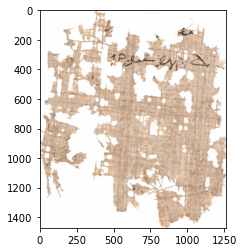

In [13]:
image = io.imread(cleansed + '/2_13894_4797LR.png')
plt.imshow(image)

In [14]:
buffer_size = 20
connectivity=2
min_area=100000
image = io.imread(cleansed + '/2_13894_4797LR.png')
gray = rgb2gray(image)
blurred_image = skimage.filters.gaussian(gray, sigma=10.0)
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
t = threshold_mean(blurred_image)
binary_mask = blurred_image < t

In [14]:
#plt.imshow()
mask = binary_mask[:, :, None] * np.ones(3, dtype=int)[None, None, :]
mask.shape

(1473, 1264, 3)

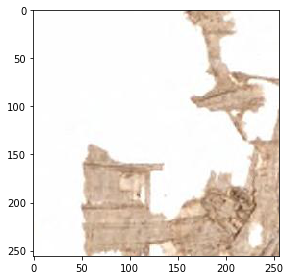

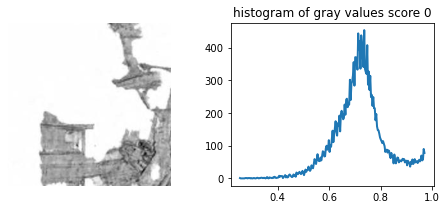

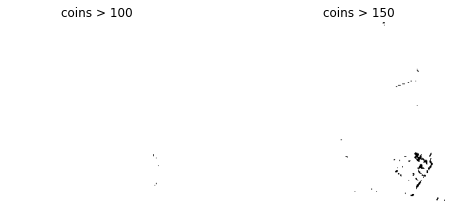

In [23]:
image = io.imread(cleansed + '/2_13894_4797LR.png')
mean_img = get_mean(image)
image = pad_image(image, 256)
patches = get_patches(image, 256)

patches = patches.numpy()
selected_metric_values = []
selected_patches = []
selected_patch_ids = []


for patch_id, patch in enumerate(patches):
    if not is_low_contrast(rgb2gray(patch.T), fraction_threshold=0.05, lower_percentile=1, upper_percentile=99):
        #io.imshow(patch.T)
        gray = rgb2gray(patch.T)
        hist, hist_centers = skimage.exposure.histogram(gray)
        hist_centers = hist_centers[:-10]
        hist = hist[:-10]
        
        arr = gray > 0.2
        #background = np.count_nonzero(arr==1)
        forground = np.count_nonzero(arr==0)
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].imshow(gray, cmap=plt.cm.gray)
        axes[0].axis('off')
        axes[1].plot(hist_centers, hist, lw=2)
        axes[1].set_title(f'histogram of gray values score {forground}')
        
#        print(type(hist))
 #       print(len(hist_centers))
  #      break
        
        

        
#        print(forground)
 #       print(background)
        
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
        axes[0].imshow(gray > 0.3, cmap=plt.cm.gray)
        axes[0].set_title('coins > 100')
        axes[1].imshow(gray > 0.5, cmap=plt.cm.gray)
        axes[1].set_title('coins > 150')

        for a in axes:
            a.axis('off')

        plt.tight_layout()
        
        
        selected_patches.append(patch)
        labels = np.ones_like(patch.T, dtype=int)                
        variance = forground
        selected_metric_values.append(variance)
        selected_patch_ids.append(patch_id)
        decending = True
        break

In [14]:
array = np.random.randint(1,10,20)
n = 40

In [18]:
#results = array[array.shape[0]-n:]
results = array[:n]

In [17]:
len(results)

20

## Create datasets
1. Got other all training, testing and validation images
2. Pad the image
3. Make m x m patches
3. Select n patches
4. Save patches with papyID_fragmentID_patchID.png
5. create and entry in the corresponding training, testing or validation csv. 


## Dataset 0 - base_line_small_small

In [28]:
dataset_config = config.get('dataset0')

In [29]:
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|███████████████████████████████████████| 752/752 [03:25<00:00,  3.66it/s]


## Dataset 1 - baseline_small_big

In [30]:
dataset_config = config.get('dataset1')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [04:38<00:00,  2.70it/s]


## Dataset 2 - baseline_small_bigger

In [31]:
dataset_config = config.get('dataset2')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [08:58<00:00,  1.40it/s]


## Dataset 3 - baseline_medium_small

In [ ]:
dataset_config = config.get('dataset3')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

## Dataset 4 - baseline_medium_big

In [58]:
dataset_config = config.get('dataset4')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [05:32<00:00,  2.26it/s]


## Dataset 5 - baseline_medium_bigger

In [34]:
dataset_config = config.get('dataset5')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [10:14<00:00,  1.22it/s]


## Dataset 6 - baseline_big_small

In [59]:
dataset_config = config.get('dataset6')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [05:33<00:00,  2.25it/s]


## Dataset 7 - baseline_big_big

In [ ]:
for i in range(2,10):
    dataset_config = config.get('dataset7')
    create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'] + str(i), dataset_config['selection'], dataset_config['m'], dataset_config['n'])

 53%|████████████████████████████████████▊                                | 401/752 [05:23<08:14,  1.41s/it]

## Dataset 8 - baseline_big_bigger

In [35]:
dataset_config = config.get('dataset8')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [11:59<00:00,  1.05it/s]


## Dataset 9 - mean_small_small

In [56]:
dataset_config = config.get('dataset9')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [04:37<00:00,  2.71it/s]


## Dataset 10 - mean_small_big

In [60]:
dataset_config = config.get('dataset10')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])v

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [12:00<00:00,  1.04it/s]


## Dataset 11 - mean_small_bigger

In [36]:
dataset_config = config.get('dataset11')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [06:43<00:00,  1.87it/s]


## Dataset 12 - mean_medium_small

In [65]:
dataset_config = config.get('dataset12')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [05:27<00:00,  2.30it/s]


## Dataset 13 - mean_medium_big

In [66]:
dataset_config = config.get('dataset13')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [06:37<00:00,  1.89it/s]


## Dataset 14 - mean_medium_bigger

In [37]:
dataset_config = config.get('dataset14')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [08:35<00:00,  1.46it/s]


## Dataset 15 - mean_big_small

In [68]:
dataset_config = config.get('dataset15')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [08:42<00:00,  1.44it/s]


## Dataset 16 - mean_big_big

In [36]:
dataset_config = config.get('dataset16')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [06:09<00:00,  2.03it/s]


## Dataset 17 - mean_big_bigger

In [38]:
dataset_config = config.get('dataset17')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [09:37<00:00,  1.30it/s]


## Dataset 18 - text_small_small

In [34]:
dataset_config = config.get('dataset18')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [06:38<00:00,  1.89it/s]


## Dataset 19 - text_small_big

In [33]:
dataset_config = config.get('dataset19')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [08:23<00:00,  1.49it/s]


## Dataset 20 - text_small_bigger

In [39]:
dataset_config = config.get('dataset20')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 752/752 [08:01<00:00,  1.56it/s]


## Dataset 21 - text_medium_small

In [31]:
dataset_config = config.get('dataset21')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [12:11<00:00,  1.03it/s]


## Dataset 22 - text_medium_big

In [31]:
dataset_config = config.get('dataset22')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [12:11<00:00,  1.03it/s]


## Dataset 23 - text_medium_bigger

In [13]:
dataset_config = config.get('dataset23')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|██████████████████████████████████████████████████████████████████████| 752/752 [09:26<00:00,  1.33it/s]


## Dataset 24 - text_big_small

In [31]:
dataset_config = config.get('dataset24')
create_datacset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [12:11<00:00,  1.03it/s]


## Dataset 25 - text_big_big

In [31]:
dataset_config = config.get('dataset25')
create_datacset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|████████████████████████████████████████████████████████████████████████| 752/752 [12:11<00:00,  1.03it/s]


## Dataset 26 - text_big_bigger

In [13]:
dataset_config = config.get('dataset26')
create_dataset(cleansed, datasets, csv, dataset_config['nr'], dataset_config['name'], dataset_config['selection'], dataset_config['m'], dataset_config['n'])

100%|██████████████████████████████████████████████████████████████████████| 752/752 [12:01<00:00,  1.04it/s]
